In [1]:
import numpy as np
import scipy as sp
from matplotlib  import pyplot as plt
import torch
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
# else:
#     device = "cpu"
device = "cpu"
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch.nn import MSELoss

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from tqdm.notebook import tqdm

import os
import shutil
torch.cuda.empty_cache()

# from subset_select_ipot import subset_select_ipot as ss_ipot
# from subset_select_FISTA import subset_select_FISTA as ss
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot

(CVXPY) Dec 19 03:08:11 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


3D Subset Selection

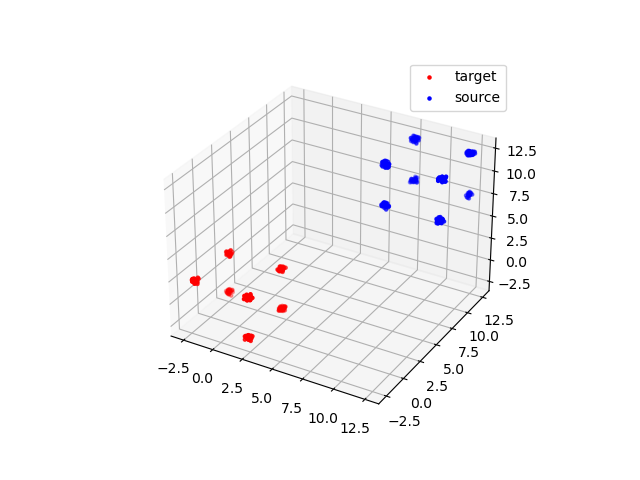

In [10]:
%matplotlib widget
torch.manual_seed(1)
d = 3
n = 256
Z = torch.rand([n, d]) - 0.5
sign_z = torch.sign(Z)
sigma_z = torch.all((sign_z == -1), dim=1)
X = Z[~sigma_z]
X = X + 2*torch.sign(X)


# Y = X + 5
Z1 = torch.rand([n, d]) - 0.5
Y = Z1 + 2*torch.sign(Z1) + 10


ax = plt.axes(projection='3d')

ax.scatter(X.T[0], X.T[1], X.T[2], marker='.',facecolor='r', edgecolors='r', label="target")
ax.scatter(Y.T[0], Y.T[1], Y.T[2], marker='.',facecolor='b', edgecolors='b', label="source")
plt.legend()


In [11]:
name_core = name_core = "\\SS\\Results\\d={0}\\".format(d)

if os.path.exists(name_core):
    shutil.rmtree(name_core)
os.makedirs(name_core)


In [17]:
torch.manual_seed(1)
max_epochs = 500
ss_max_iter = 2000
wd = 2
gamma = 0.01

# Lts = [1, 0.125*Y.shape[0], 0.25*Y.shape[0], 0.875*Y.shape[0], 0.50*Y.shape[0], 0.625*Y.shape[0], 0.75*Y.shape[0], 0.875*Y.shape[0], Y.shape[0]]
cs = [1, 1.25, 1.50, 1.75, 2, 4, 8, 16]
X = X.to(device)
Y = Y.to(device)


class AffineNet(nn.Module):
    def __init__(self, i_dim):
        super(AffineNet, self).__init__()
        self.A = nn.parameter.Parameter(
            torch.eye(i_dim, dtype=torch.double, requires_grad=True))
        self.b = nn.parameter.Parameter(torch.zeros(
            [1, i_dim], dtype=torch.double, requires_grad=True))

    def forward(self, Y):
        return torch.mm(Y, self.A) + self.b


# Affine_MAP = AffineNet(2).to(device)
# adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.1,
#                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0)



for c in cs:
    costs = []
    Affine_MAP = AffineNet(d).to(device)
    adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    print("c=",c)
    for epoch in range(0, max_epochs):
        adam.zero_grad()
        Y_transfomed = Affine_MAP(Y)
        C = torch.norm(X[:, None, :] - Y_transfomed, dim=2, p=2)**wd
        mu = np.ones([X.shape[0], 1])/X.shape[0]
        nu = np.ones([Y.shape[0], 1])/Y.shape[0]
        
        M = C.detach().cpu().numpy()
        M = M/np.max(M)
        K = np.exp(-M/gamma)
        # subset_select_non_uniform_FISTA(mu, nu, c, K, M, gamma=1e-1, Lt=1e-1, eta = 1.1, max_iter = 20000, back_tracking = False, disp_iter=False):
        P, _, _, _ = ss(mu, nu, c, K, M, gamma=gamma, Lt=1/gamma, max_iter=ss_max_iter,  disp_iter=False)
        # _, P = ss_ipot(X.detach().cpu().numpy(), Y_transfomed.detach().cpu().numpy(), mu, gamma, L=L, max_outer_iter=max_outer_iter,
        #                max_inner_iter=max_inner_iter, wd=wd, disp_iter=False, return_map=True)
        P = torch.tensor(P, dtype=torch.double, device=device, requires_grad=False)
        # print(P.shape)
        cost = torch.sum(P*C)
        cost.backward()
        adam.step()
        costs.append(cost.item())
        print(f'Epoch {epoch} Loss {cost.item():.4f}')
    
    path = name_core + "d="+ str(d) + "c=" + str(c)+".pth"
    torch.save({'AM_infer': Affine_MAP.state_dict(), "costs":costs}, path)

c= 1
Epoch 0 Loss 287.1207
Epoch 1 Loss 106.3267
Epoch 2 Loss 240.0309
Epoch 3 Loss 68.0398
Epoch 4 Loss 11.3293
Epoch 5 Loss 103.5064
Epoch 6 Loss 124.3786
Epoch 7 Loss 50.9109
Epoch 8 Loss 5.3884
Epoch 9 Loss 35.7240
Epoch 10 Loss 75.0848
Epoch 11 Loss 61.3377
Epoch 12 Loss 19.8956
Epoch 13 Loss 6.2527
Epoch 14 Loss 28.3761
Epoch 15 Loss 47.1283
Epoch 16 Loss 35.1525
Epoch 17 Loss 11.4700
Epoch 18 Loss 6.8180
Epoch 19 Loss 20.8612
Epoch 20 Loss 30.1130
Epoch 21 Loss 21.3175
Epoch 22 Loss 7.9907
Epoch 23 Loss 6.8814
Epoch 24 Loss 15.9106
Epoch 25 Loss 19.8974
Epoch 26 Loss 13.0814
Epoch 27 Loss 5.8461
Epoch 28 Loss 7.4415
Epoch 29 Loss 12.8671
Epoch 30 Loss 13.3680
Epoch 31 Loss 8.4495
Epoch 32 Loss 5.4302
Epoch 33 Loss 7.5288
Epoch 34 Loss 10.3411
Epoch 35 Loss 9.0373
Epoch 36 Loss 5.8574
Epoch 37 Loss 5.5730
Epoch 38 Loss 7.6074
Epoch 39 Loss 8.1485
Epoch 40 Loss 6.4987
Epoch 41 Loss 5.2442
Epoch 42 Loss 5.8931
Epoch 43 Loss 6.8172
Epoch 44 Loss 6.2482
Epoch 45 Loss 5.1734
Epoch 46 

#IPOT

In [18]:
name_core = "\\SS-ipot\\Results\\d={0}\\".format(d)
if os.path.exists(name_core):
    shutil.rmtree(name_core)
os.makedirs(name_core)


In [21]:
torch.manual_seed(1)

max_outer_iter = 100
max_inner_iter = 500
max_epochs = 500
gamma = 0.01
wd = 2

# Lts = [1, 0.125*Y.shape[0], 0.25*Y.shape[0], 0.375*Y.shape[0], 0.50*Y.shape[0], 0.625*Y.shape[0], 0.75*Y.shape[0], 0.875*Y.shape[0], Y.shape[0]]
cs = [1, 1.25, 1.50, 1.75, 2, 4, 8, 16]
X = X.to(device)
Y = Y.to(device)


class AffineNet(nn.Module):
    def __init__(self, i_dim):
        super(AffineNet, self).__init__()
        self.A = nn.parameter.Parameter(torch.eye(i_dim, dtype=torch.double, requires_grad=True))
        self.b = nn.parameter.Parameter(torch.zeros([1, i_dim], dtype=torch.double, requires_grad=True))
    
    def forward(self, Y):
        return torch.mm(Y, self.A) + self.b


# Affine_MAP = AffineNet(2).to(device)
# adam = torch.optim.Adam(Affine_MAP.parameters(), lr=1,
#                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# if cost.detach().item() < cost_best:
#                 cost_best = cost.detach().item()
#                 AM_infer = AffineMap().to(device)
#                 AM_infer.load_state_dict(AM.state_dict())

#     path = name_core + "L=" + str(Lt)+".pth"
#     torch.save({'AM_infer': AM_infer.state_dict(), "costs":costs}, path)

for c in cs:
    costs = []
    Affine_MAP = AffineNet(d).to(device)
    adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    print("c=", c)
    for epoch in range(0, max_epochs):
        adam.zero_grad()
        Y_transfomed = Affine_MAP(Y)
        C = torch.norm(X[:, None, :] - Y_transfomed, dim=2, p=2)**wd
        mu = np.ones([X.shape[0], 1])/X.shape[0]
        nu = np.ones([Y.shape[0],1])/Y.shape[0]
        
        _, P, _, _ = ss_ipot(X.detach().cpu().numpy(), Y_transfomed.detach().cpu().numpy(), mu, nu, c, gamma, max_outer_iter=max_outer_iter, return_map=True)
        
        # subset_select_ipot(X, Y, mu, nu, c,  gamma, max_outer_iter, max_inner_iter = 20 , wd = 2, disp_iter = False, return_map = False)
        
        P = torch.tensor(P, dtype=torch.double, device=device, requires_grad=False)
        # print(P.shape)
        cost = torch.sum(P*C)
        cost.backward()
        adam.step()
        costs.append(cost.item())
        print(f'Epoch {epoch} Loss {cost.item():.4f}')
    
    path = name_core + "d="+ str(d) + "c=" + str(c)+".pth"
    torch.save({'AM_infer': Affine_MAP.state_dict(), "costs":costs}, path)

c= 1
Epoch 0 Loss 227.5932
Epoch 1 Loss 96.8778
Epoch 2 Loss 152.6493
Epoch 3 Loss 25.6696
Epoch 4 Loss 28.1032
Epoch 5 Loss 93.3668
Epoch 6 Loss 65.3792
Epoch 7 Loss 9.1203
Epoch 8 Loss 18.6763
Epoch 9 Loss 56.4266
Epoch 10 Loss 49.4220
Epoch 11 Loss 14.3099
Epoch 12 Loss 5.8893
Epoch 13 Loss 28.2050
Epoch 14 Loss 37.2557
Epoch 15 Loss 20.1606
Epoch 16 Loss 4.2582
Epoch 17 Loss 11.6932
Epoch 18 Loss 24.7175
Epoch 19 Loss 21.1403
Epoch 20 Loss 8.0587
Epoch 21 Loss 4.8100
Epoch 22 Loss 13.8400
Epoch 23 Loss 17.1355
Epoch 24 Loss 9.2550
Epoch 25 Loss 3.9363
Epoch 26 Loss 8.3235
Epoch 27 Loss 12.7012
Epoch 28 Loss 9.7041
Epoch 29 Loss 4.6105
Epoch 30 Loss 5.3549
Epoch 31 Loss 9.5115
Epoch 32 Loss 8.5094
Epoch 33 Loss 4.4039
Epoch 34 Loss 4.6942
Epoch 35 Loss 7.2742
Epoch 36 Loss 7.1579
Epoch 37 Loss 4.6886
Epoch 38 Loss 4.0844
Epoch 39 Loss 5.9590
Epoch 40 Loss 5.9267
Epoch 41 Loss 4.0108
Epoch 42 Loss 4.1007
Epoch 43 Loss 5.5337
Epoch 44 Loss 5.0058
Epoch 45 Loss 3.7159
Epoch 46 Loss 4.1